# Comparison of Gradient and Hessian Estimation for Resampling Methods

We are interested in comparing: 

\begin{enumerate}
    \item \textbf{Bias in gradient estimates}: Determining which method is the least biased for a large number of particles
    \item \textbf{Relationship between bias and inference time}: Does the bias for each method decrease with the amount of compute time (i.e. number of samples)
    \item \textbf{Variance in gradient estimates}: Are the signs of the gradient estimates correct for each resampling method. If this is not the case for a particular resampling method, the stochastic optimizer can get stuck or go in the wrong direction
\end{enumerate}


In [1]:
import time
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import projplot.proj_plot as pjp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.random as random

import pfjax as pf
from pfjax import particle_resamplers as resampler
from pfjax.models import BMModel
from pfjax.experimental.models import LotVolModelLog
import optax
from jax import lax
from functools import partial

import warnings
warnings.filterwarnings('ignore')

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
from pfjax.utils import lwgt_to_prob, continuous_cdf, interpolate_weights, argsort_marginal

## Brownian Motion Model with Drift

\begin{align*}
    x_0 &\sim N(0, \sigma^2 \Delta t) \\
    x_t &\sim N(x_{t-1} + \mu \Delta t, \sigma^2 \Delta t) \\
    y_t &\sim N(x_t, \tau^2) \\
    \boldsymbol{\theta} &= (\mu, \sigma, \tau) 
\end{align*}

The true parameter values used are: 

\begin{align*}
\boldsymbol{\theta} &= (\mu = 0.25, \sigma = 0.5, \tau = 0.2) \\
\Delta t &= 0.1 \\ 
n &= 100 \\
x_0 &= 0
\end{align*}

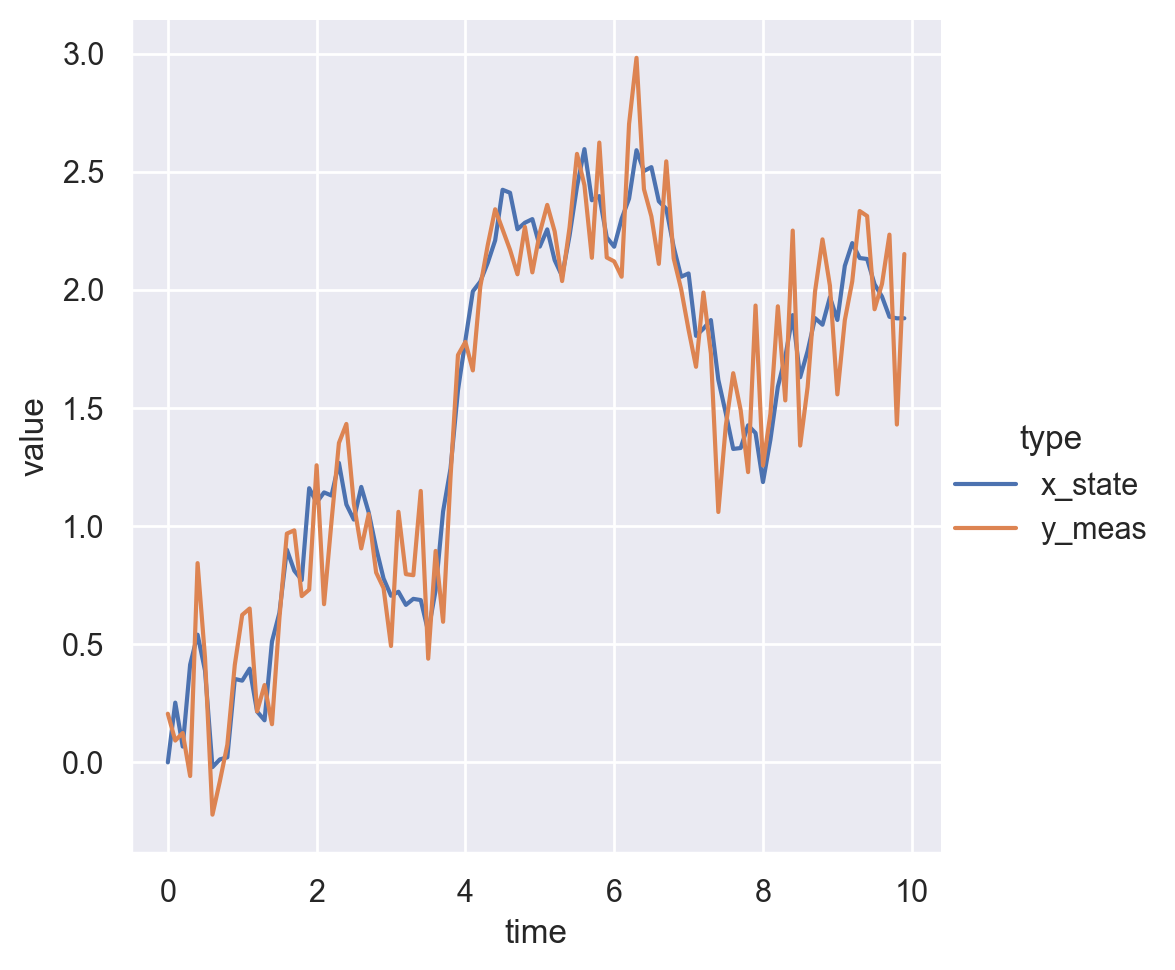

In [164]:
# parameter values
mu = 0.25
sigma = .5
tau = .2
theta_true_bm = jnp.array([mu, sigma, tau])

# data specification
dt = .1
n_obs = 100
x_init = jnp.array(0.)

# initial key for random numbers
key = jax.random.PRNGKey(0)

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = jax.random.split(key)
y_meas_bm, x_state_bm = pf.simulate(
    model=bm_model,
    key=subkey,
    n_obs=n_obs,
    x_init=x_init,
    theta=theta_true_bm
)

# projection plot specification
n_pts = 100 # number of evaluation points per plot
theta_lims_bm = jnp.array([[-.35, .85], [.2, .8], [.05, .45]])  # plot limits for each parameter
theta_names_bm = ["mu", "sigma", "tau"] # parameter names

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state_bm),
                         "y_meas": jnp.squeeze(y_meas_bm)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
);

### Log-likelihood Projection Plot

In [165]:
def resample_continuous_bm (key, x_particles_prev, logw):
    """
    Continuous CDF resampler for the Brownian motion model with drift
    """
    p_shape = x_particles_prev.shape
    n_particles = p_shape[0]
    prob = lwgt_to_prob(logw)

    sorted_marginals = argsort_marginal(x_particles_prev, prob)

    U = random.uniform(key, shape=(n_particles,))
    x_particles = jax.vmap(
        lambda u: continuous_cdf(sorted_marginals["x"], sorted_marginals["w"], u), in_axes = (0))(U)
    return {
        "x_particles": x_particles,
    }

def bm_neg_loglik_exact(theta, y_meas):
    """
    Exact negative loglikelihood of the BM model.
    """
    theta = jnp.atleast_2d(theta)
    return -jax.vmap(lambda _theta: bm_model.loglik_exact(
        y_meas=y_meas, 
        theta=_theta
    ))(theta)[0]


# @partial(jax.jit, static_argnums=(2,3,))
def neg_loglik(theta, y_meas, model, key, n_particles=500, resample_fn=resampler.resample_multinomial):
    """ negative log-likelihood of PF with continuous resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resample_fn,
        history = False)
    return -ret["loglik"]


# set the max_iterations to 10 to reduce runtimes
pointcloud_kwargs = {}
sinkhorn_kwargs = {"max_iterations": 10,
                   "min_iterations": 10}
def resample_ot_jit(key, x_particles_prev, logw):
    return resampler.resample_ot(key, x_particles_prev, logw,
                                 pointcloud_kwargs = pointcloud_kwargs,
                                 sinkhorn_kwargs = sinkhorn_kwargs)

In [170]:
def loglik_compare (estimators, estimator_names, theta_true, theta_lims, theta_names, n_pts=100):
    """
    Return plot/df to compare log-likelihood estimators
    
    Args: 
        - estimators: list of estimators 
        - estimator_names: name of estimators used when combining the projection plots
        - plot: boolean whether or not to plot the projection plots
        - args: theta_true, theta_lims, theta_names, n_pts
    Returns
    """
    assert len(estimator_names) == len(estimators)
    df_list = []
    for i, est in enumerate(estimators):
        _proj_plot = pjp.proj_plot(
            fun=est,
            x_opt=theta_true, 
            x_lims=theta_lims, 
            x_names=theta_names, 
            n_pts=n_pts,
            vectorized=False,
            plot=False
        )
        df_list.append(_proj_plot)
        
    plot_df = pd.concat(df_list, ignore_index=True)
    plot_df["Resampler"] = np.repeat(estimator_names, _proj_plot.shape[0])
    plot_df = plot_df.rename(columns={"y": "neg-loglikelihood"})
    return plot_df


def approx_score_fn (loglik, theta_true, theta_lims, theta_names, n_pts=100):
    """
    Approximate the profile log-likelihood, `loglik` with a cubic regression 
    
    Args: 
        - loglik: negative loglikelihood function to be passed to pjp.proj_plot, function accepting theta only
        - theta_true: True value of theta
        - theta_lims: limits for each value of theta for which to calculate the profile likelihood
        - theta_names: names
        - grad_fn: Default None, if specified this is the gradient of the log-likelihood, which is evaluated over the grid (theta_lims)
        
    Returns: 
        - Dataframe of log-likelihood approximation 
        - Plot of log-likelihood and its approximation 
        - Values of the (approximate) score funciton evaluated at the true parameter values
    """
    
    ## estimate of log-likelihood:
    mc_loglik_df = pjp.proj_plot(
        fun=loglik,
        x_opt=theta_true, 
        x_lims=theta_lims, 
        x_names=theta_names, 
        n_pts=n_pts,
        plot=False
    )
    
    # log-likelihood approximation with regression: 
    data = mc_loglik_df.copy()
    data["y_hat"] = np.ones(data.shape[0])
    data["loglik_grad"] = np.ones(data.shape[0])

    true_grad = np.zeros(len(theta))
    for i, _param in enumerate(mc_loglik_df.x_opt.unique()):
        tmp_data = mc_loglik_df[mc_loglik_df.x_opt == _param].reset_index(drop = True)

        # fit quadratic regression: y = x^3 + x^2 + x + c
        X = pd.DataFrame(np.stack([np.ones(tmp_data.shape[0]), 
                                   tmp_data["x"], 
                                   tmp_data["x"]**2,
                                   tmp_data["x"]**3], axis = 1).astype('float64'), 
                         columns=["intercept", "x", "x^2", "x^3"]).reset_index(drop = True)
        beta_hat = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, tmp_data["y"]))
        # cast to array to avoid index issues
        data.loc[data.x_opt == _param, "y_hat"] = np.array(np.matmul(X, beta_hat))

        # estimate grad on grid (theta_lims):
        loglik_grad = np.array(beta_hat[1] + 2*beta_hat[2]*tmp_data["x"] + 3*beta_hat[3]*tmp_data["x"]**2)
        data.loc[data.x_opt == _param, "loglik_grad"] = loglik_grad
        
        # score function evaluated at the true parameters: (beta_1 + 2*beta_2 + 3*beta_3^2)
        true_grad[i] = np.array(beta_hat[1] + 2*beta_hat[2]*theta[i] + 3*beta_hat[3]*theta[i]**2)
    
    return true_grad, data

In [97]:
# projection plots for multinomial
n_particles_multinom = 1000
n_particles_ot = 100
n_particles_mvn = 200
n_particles_gc = 500
key, subkey = jax.random.split(key)

# multinom resampling
bm_multinom = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_bm,
    model = bm_model,
    key=subkey,
    n_particles=n_particles_multinom,
    resample_fn = resampler.resample_multinomial))

# continuous CDF resampling
bm_cont = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_bm,
    model = bm_model,
    key=subkey,
    n_particles=n_particles_gc,
    resample_fn = resample_continuous_bm))

# MVN resampling
bm_mvn = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_bm,
    model = bm_model,
    key=subkey,
    n_particles=n_particles_mvn,
    resample_fn = resampler.resample_mvn))

# OTT resampling
bm_ott = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_bm,
    model = bm_model,
    key=subkey,
    n_particles=n_particles_ot,
    resample_fn = resample_ot_jit))

%timeit bm_multinom(theta_true_bm)
%timeit bm_cont(theta_true_bm)
%timeit bm_mvn(theta_true_bm)
%timeit bm_ott(theta_true_bm)

8.77 ms ± 354 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
71.3 ms ± 722 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.76 ms ± 63.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
292 ms ± 2.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [98]:
# function to create projection plots for each log-likelihood estimator:
plot_args = {
    "theta_true": theta_true_bm,
    "theta_lims": theta_lims_bm,
    "theta_names": theta_names_bm,
    "n_pts": n_pts
}

plot_df = loglik_compare(
    [bm_multinom, bm_mvn, bm_cont],
    ["Multinomial", "MVN", "Continuous"],
    *plot_args
)

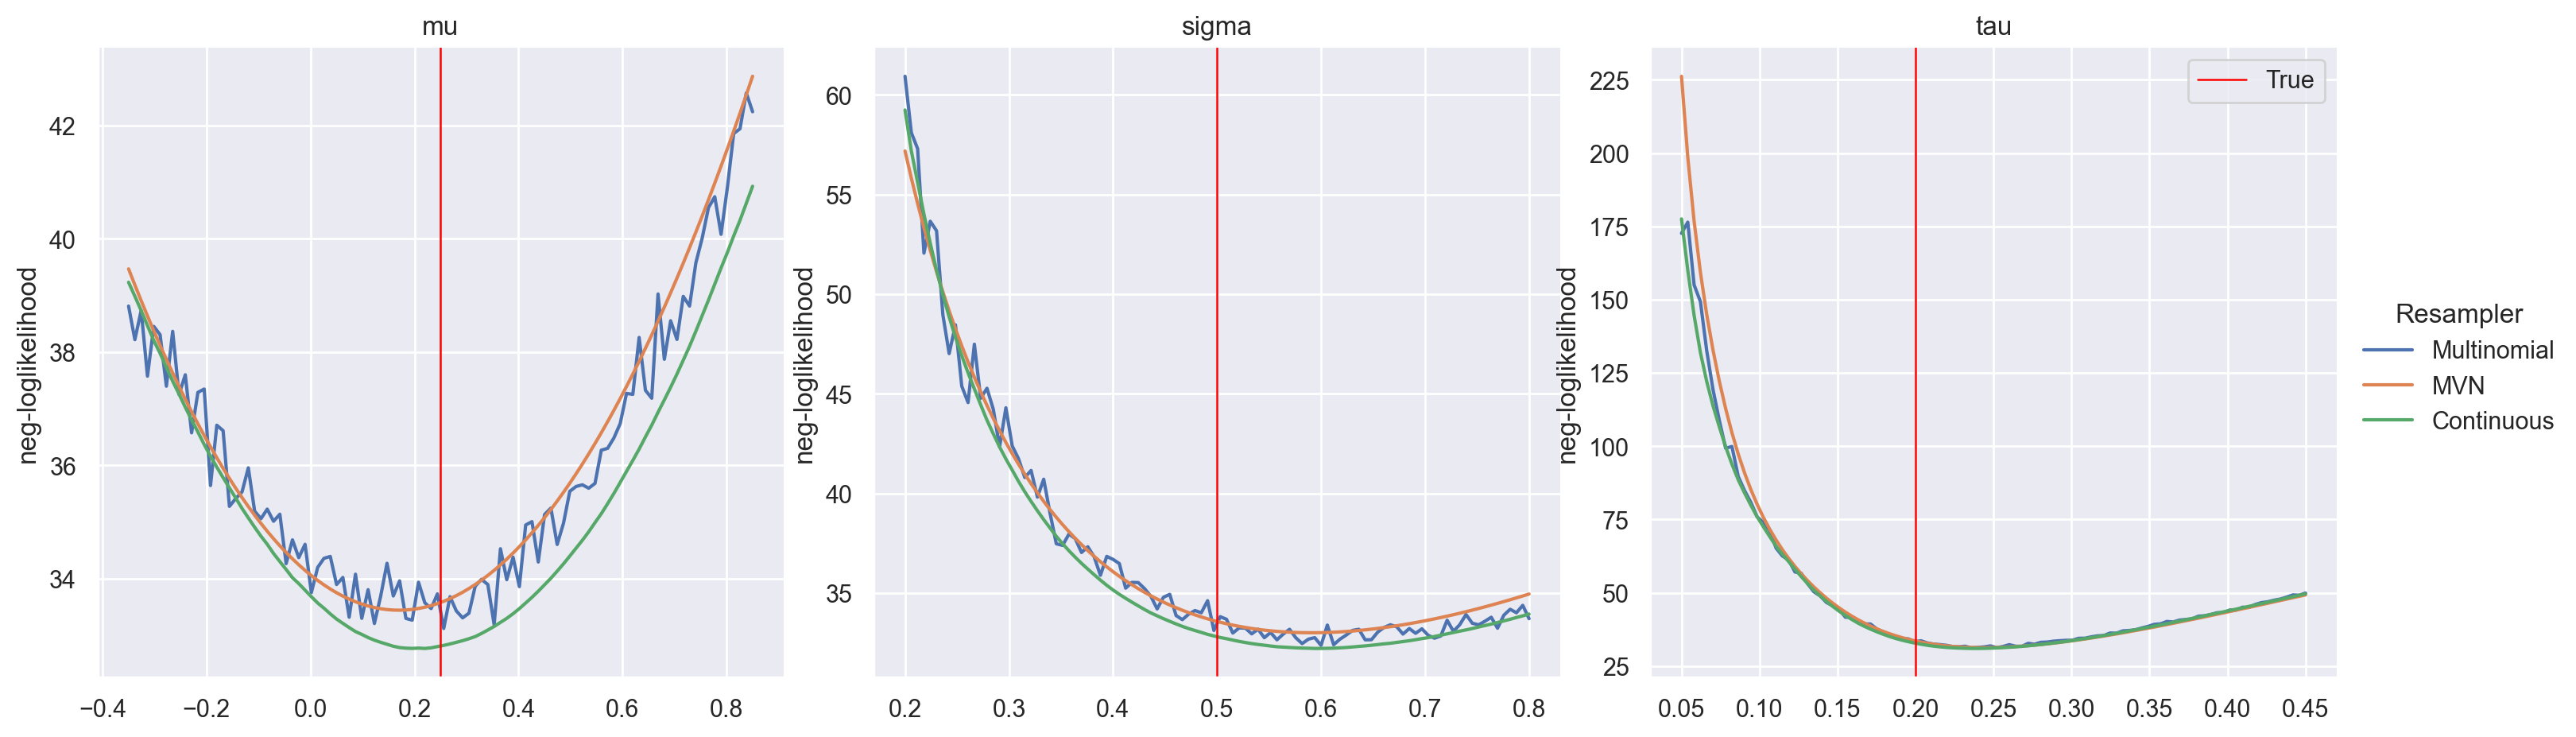

In [99]:
grid = sns.relplot(
    data=plot_df,
    kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 3,
    facet_kws=dict(sharex=False, sharey=False)
)

grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None);

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta_true_bm[ind], color='red', lw = 0.9, label="True")

_ax.legend();

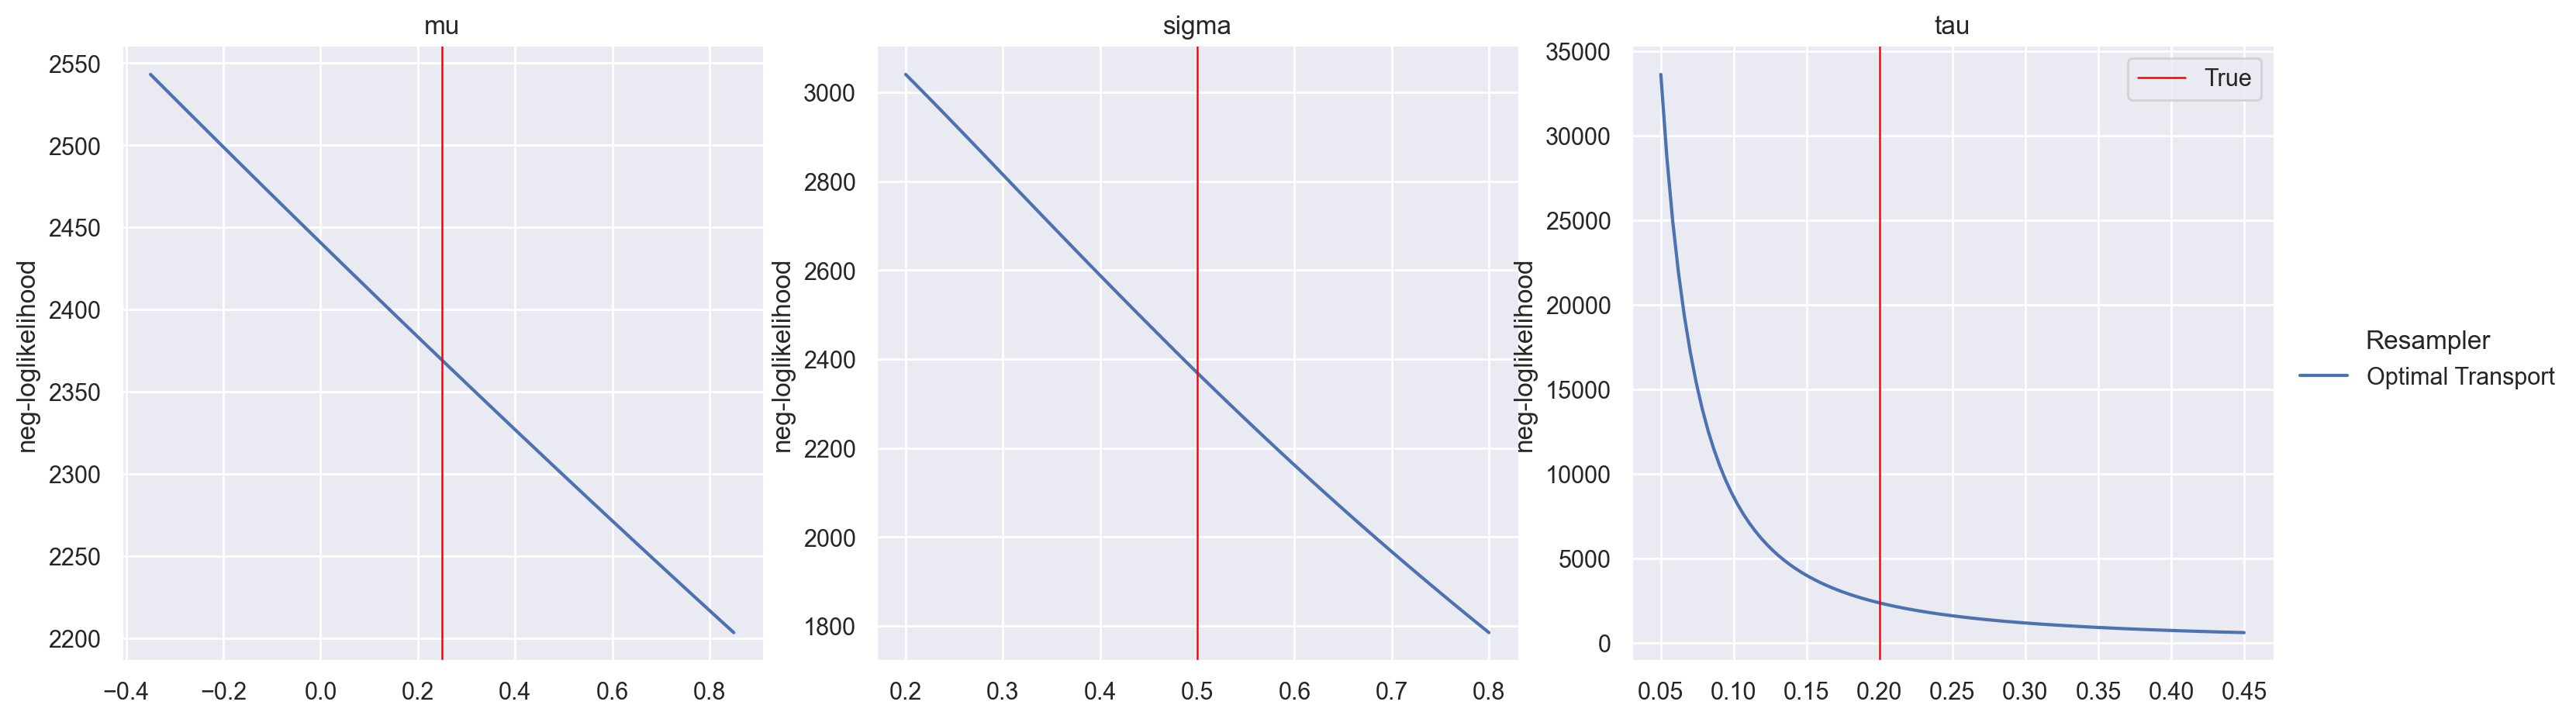

In [81]:
# function to create projection plots for each log-likelihood estimator:
ott_df = loglik_compare(
    [bm_ott],
    ["Optimal Transport"],
    *plot_args
)

grid = sns.relplot(
    data=ott_df,
    kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 3,
    facet_kws=dict(sharex=False, sharey=False)
)

grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None);

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta_true_bm[ind], color='red', lw = 0.9, label="True")
_ax.legend();

### Check Score Function

In [167]:
# # score function for different resampling schemes: 
bm_loglik = partial(neg_loglik, model=bm_model, y_meas = y_meas_bm)
bm_score_exact = jax.jit(jax.grad(partial(bm_neg_loglik_exact, y_meas=y_meas_bm)))

# multinomial resampling:
@partial(jax.jit, static_argnums=(2,))
def bm_score_multinom(theta, key, n_particles):
    return jax.grad(bm_loglik)(theta, key=key, n_particles=n_particles)

# MVN resampling: 
@partial(jax.jit, static_argnums=(2,))
def bm_score_mvn(theta, key, n_particles):
    return jax.grad(bm_loglik)(theta, key=key, n_particles=n_particles, 
                               resample_fn = pf.particle_resamplers.resample_mvn)

# continuous CDF resampling: 
@partial(jax.jit, static_argnums=(2,))
def bm_score_cont(theta, key, n_particles):
    return jax.grad(bm_loglik)(theta, key=key, n_particles=n_particles, 
                               resample_fn = resample_continuous_bm)

In [168]:
key = random.PRNGKey(0)
n_particles = 100
n_sim = 30
key, *subkeys = random.split(key, n_sim+1)

# repeat calculation nsim times
score_exact = bm_score_exact(theta_true_bm)
score_multinom = []
score_mvn = []
score_cont = []

for i in range(n_sim):
    score_multinom += [bm_score_multinom(theta_true, subkeys[i], n_particles=n_particles)]
    score_mvn += [bm_score_mvn(theta_true, subkeys[i], n_particles=n_particles)]
    score_cont += [bm_score_cont(theta_true, subkeys[i], n_particles=n_particles)]

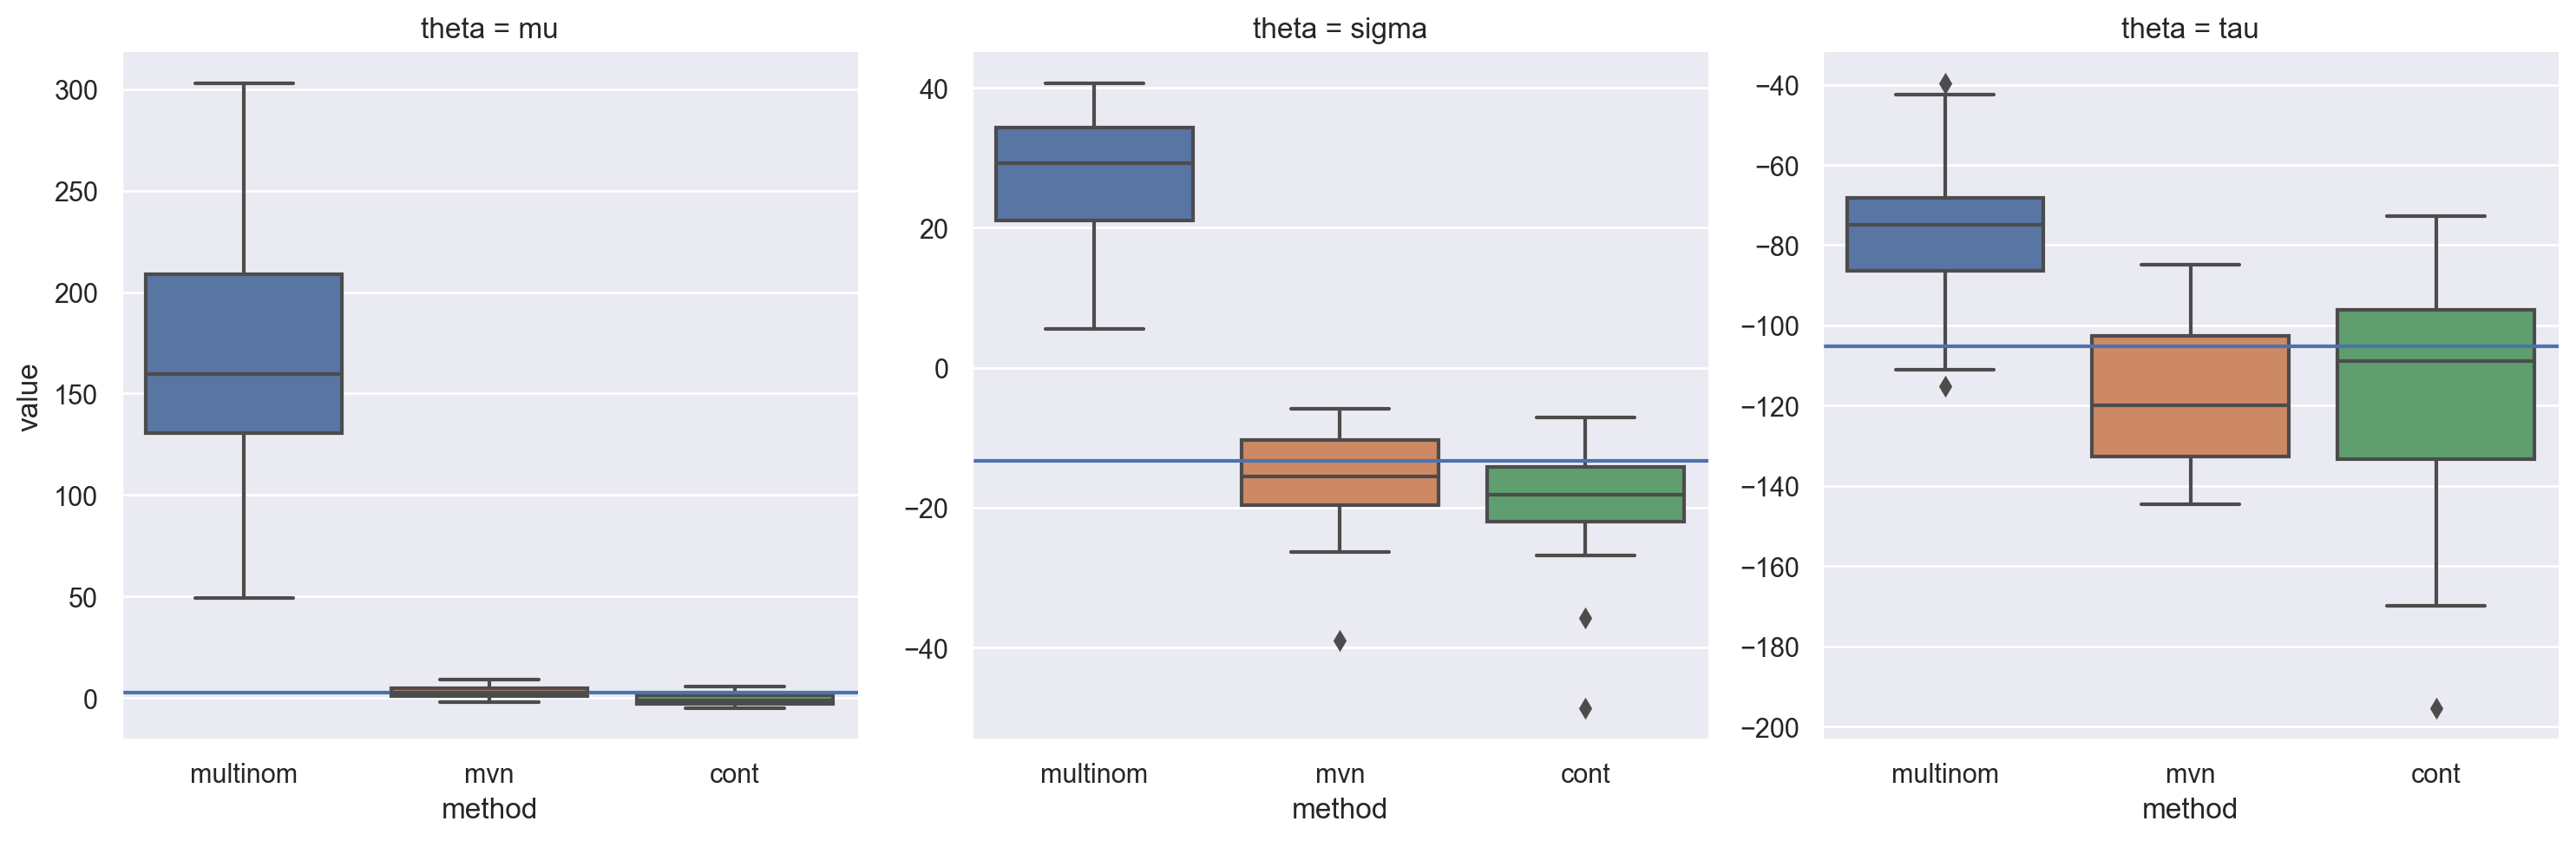

In [169]:
score_df = (
    pd.DataFrame({
    "theta": np.tile(theta_names, n_sim),
    "multinom": np.array(score_multinom).ravel(),
    "mvn": np.array(score_mvn).ravel(),
    "cont": np.array(score_cont).ravel()
})
    .melt(id_vars=["theta"], value_vars=["multinom", "mvn", "cont"], var_name="method")
)

g = sns.catplot(
    data=score_df,
    kind="box",
    x="method", y="value",
    col="theta",
    col_wrap=3,
    sharey=False
)
[g.axes[i].axhline(score_exact[i]) for i in range(theta_true_bm.size)];

### Check Fisher Information

## Lotka-Volterra Model


- **write model**

In [171]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta_true_lv = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])
theta_names_lv = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
theta_lims_lv = np.array(list(zip(theta_true_lv - (theta_true_lv/2), theta_true_lv + (theta_true_lv/2))))

dt = 0.1
n_res = 1
n_obs = 100

_key = random.PRNGKey(0)
_key, _subkey = random.split(_key)

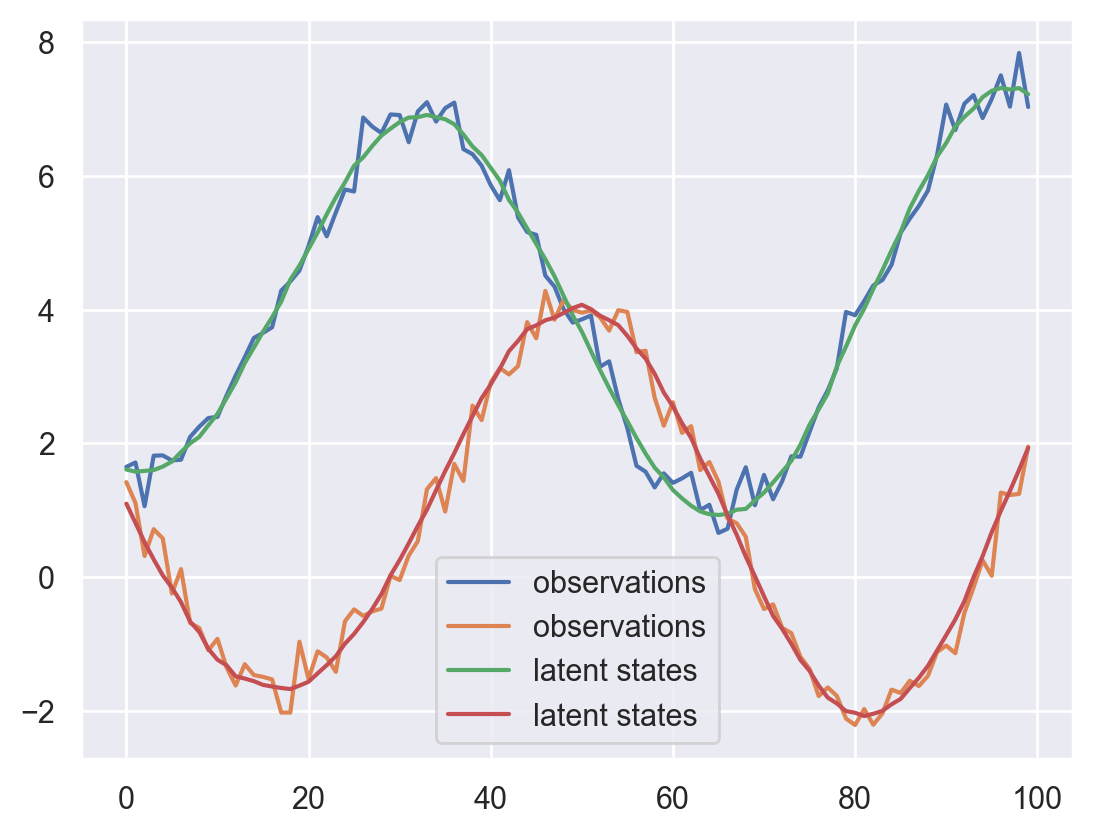

In [172]:
lotvol_model = LotVolModelLog(dt, n_res, bootstrap = True) 
theta_true_lv = jnp.log(theta_true_lv)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])

y_meas_lv, x_state_lv = pf.simulate(model = lotvol_model, 
                              n_obs = n_obs, 
                              x_init = x_init, 
                              theta = theta_true_lv, 
                              key = _subkey)

plt.plot(y_meas_lv, label = "observations");
plt.plot(x_state_lv.squeeze(), label = "latent states")
plt.legend();

In [173]:
theta_lims_lv = jnp.log(jnp.array([
    [0.8, 1.2],
    [0.9, 1.1],
    [3.8, 4.2],
    [0.95, 1.05],
    [0.05, 0.2],
    [0.01, 0.2],
    [0.1, 0.4],
    [0.1, 0.4]]))

In [174]:
# projection plots for multinomial
n_particles_multinom = 1000
n_particles_ot = 100
n_particles_mvn = 200
n_particles_gc = 500
key, subkey = jax.random.split(key)

# multinom resampling
lv_multinom = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_lv,
    model = lotvol_model,
    key=subkey,
    n_particles=n_particles_multinom,
    resample_fn = resampler.resample_multinomial))

# continuous CDF resampling
lv_gc = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_lv,
    model = lotvol_model,
    key=subkey,
    n_particles=n_particles_gc,
    resample_fn = resample_continuous_bm))

# MVN resampling
lv_mvn = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_lv,
    model = lotvol_model,
    key=subkey,
    n_particles=n_particles_mvn,
    resample_fn = resampler.resample_mvn))

# OTT resampling
lv_ott = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_lv,
    model = lotvol_model,
    key=subkey,
    n_particles=n_particles_ot,
    resample_fn = resample_ot_jit))

%timeit lv_multinom(theta_true_lv)
%timeit lv_gc(theta_true_lv)
%timeit lv_mvn(theta_true_lv)
%timeit lv_ott(theta_true_lv)

35.1 ms ± 5.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
111 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.44 ms ± 654 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
311 ms ± 8.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [175]:
# function to create projection plots for each log-likelihood estimator:
plot_args_lv = {
    "theta_true": theta_true_lv,
    "theta_lims": theta_lims_lv,
    "theta_names": theta_names_lv,
    "n_pts": 100
}

plot_df_lv = loglik_compare(
    [lv_multinom, lv_mvn, lv_gc],
    ["Multinomial", "MVN", "Gaussian Copula"], 
    **plot_args_lv
)

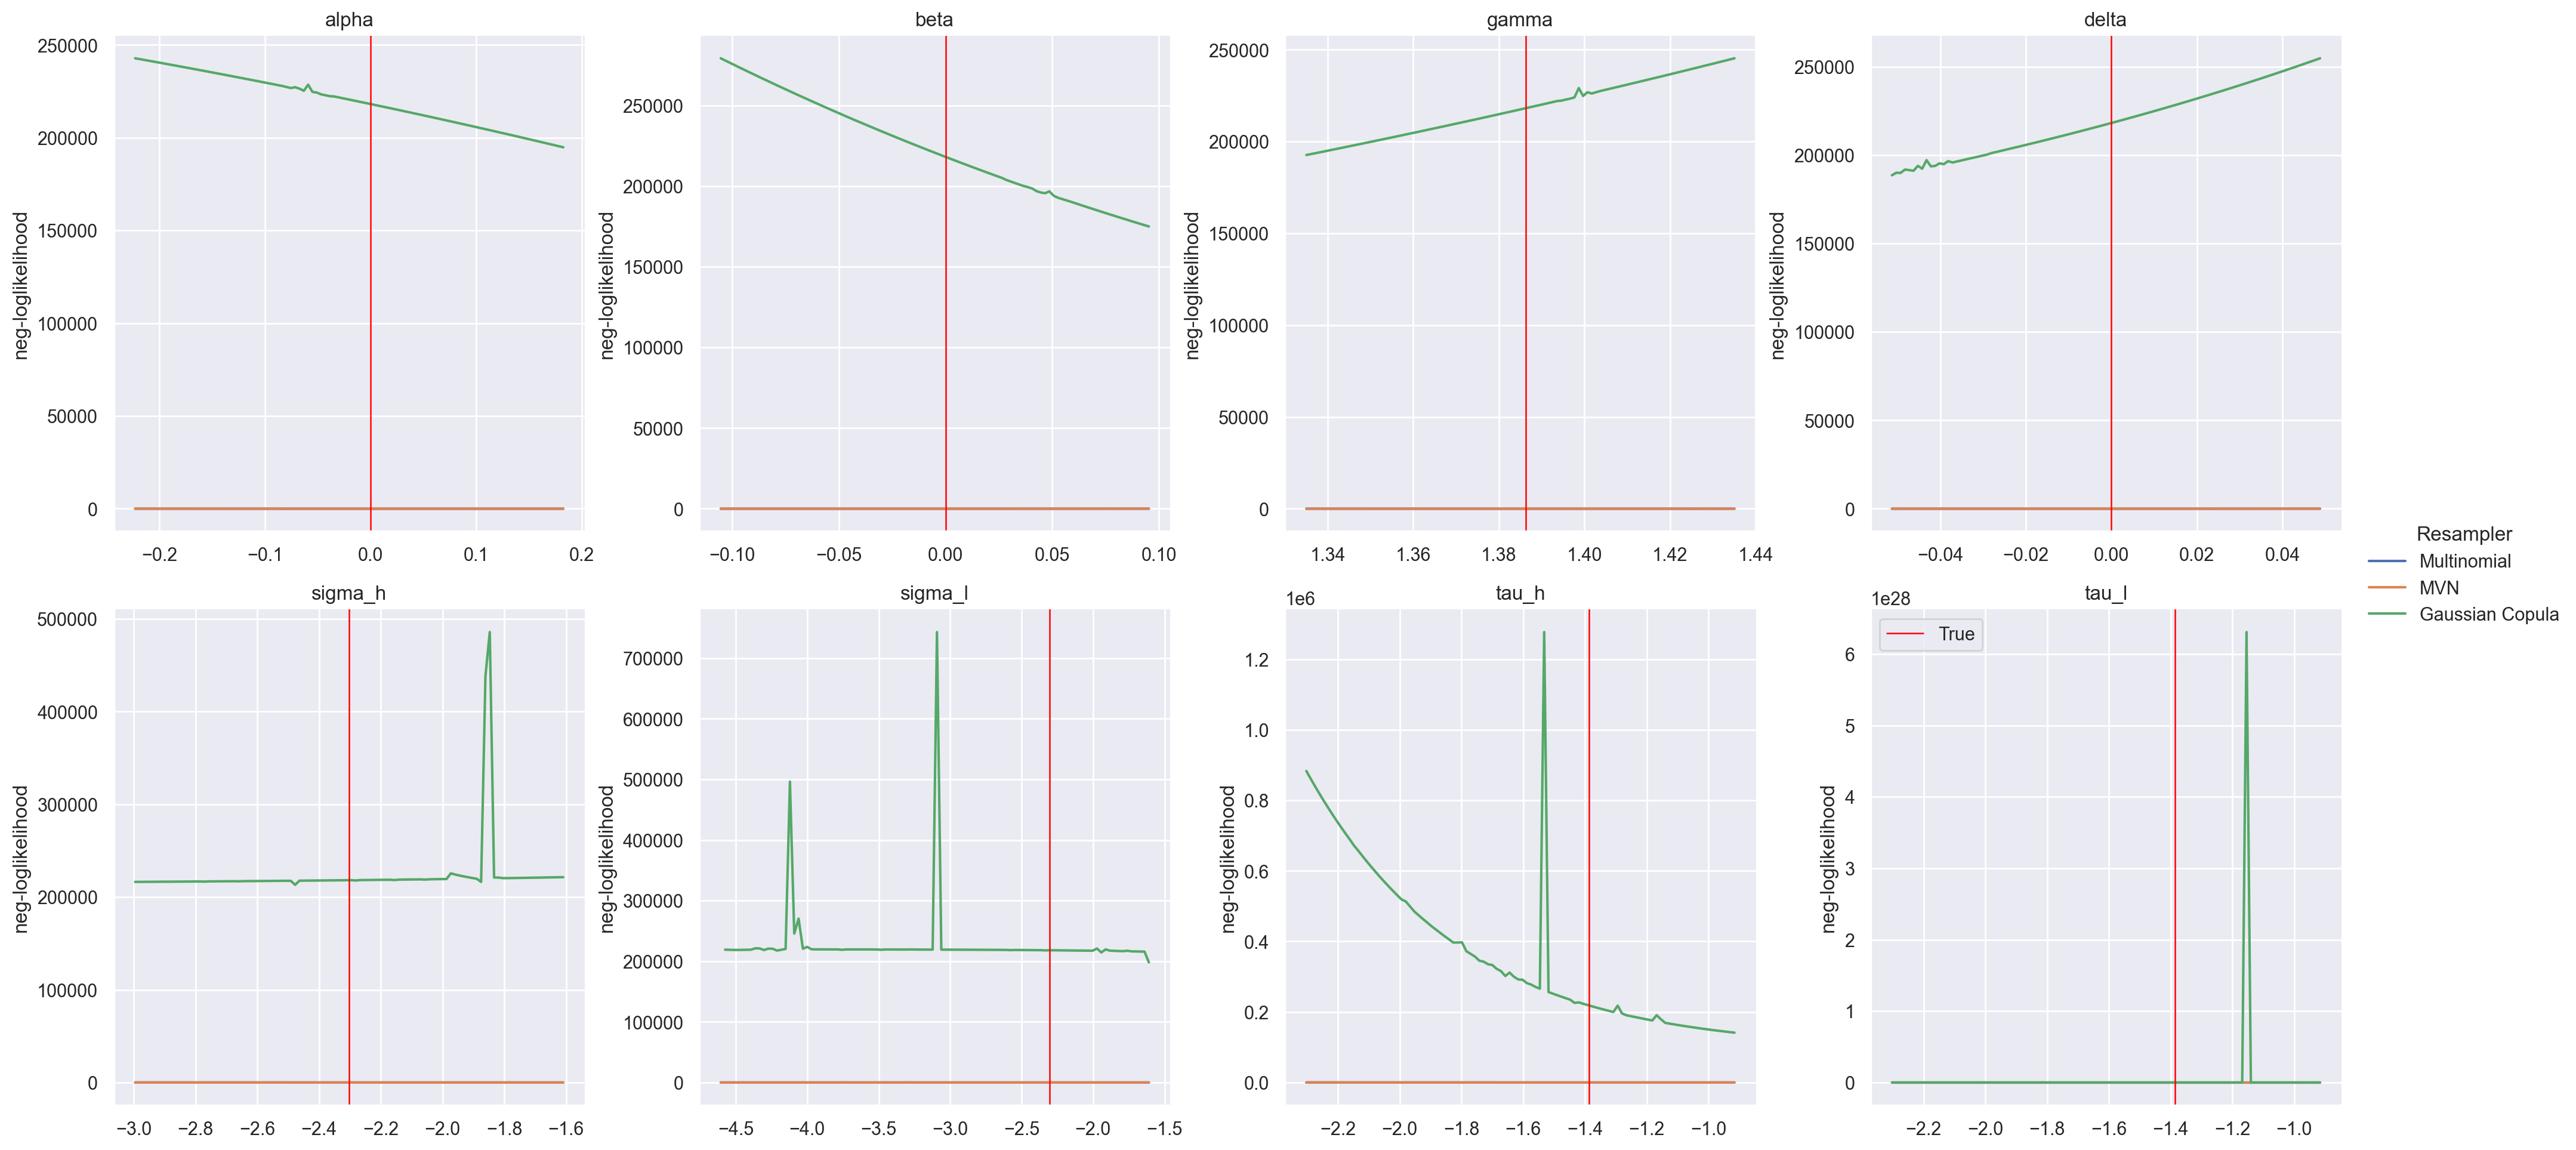

In [176]:
grid = sns.relplot(
    data=plot_df_lv,
    kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None);

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta_true_lv[ind], color='red', lw = 0.9, label="True")

_ax.legend();

### Check Score Function

In [211]:
lotvol_neg_loglik = partial(neg_loglik, y_meas = y_meas_lv, model=lotvol_model)

# various score functions
@partial(jax.jit, static_argnums=(2,))
def lv_score_multinom(theta, key, n_particles):
    return jax.grad(lotvol_neg_loglik)(theta, key=key, n_particles=n_particles)

@partial(jax.jit, static_argnums=(2,))
def lv_score_mvn(theta, key, n_particles):
    return jax.grad(lotvol_neg_loglik)(theta, key=key, n_particles=n_particles,
                                       resample_fn=resampler.resample_mvn)

@partial(jax.jit, static_argnums=(2,))
def lv_score_gc(theta, key, n_particles):
    return jax.grad(lotvol_neg_loglik)(theta, key=key, n_particles=n_particles,
                                       resample_fn=resampler.resample_gaussian_copula)

In [ ]:
# approximate log-likelihood with cubic regression: 
key, subkey = random.split(key)
lv_multinom_true = jax.jit(partial(
    neg_loglik,
    y_meas = y_meas_lv,
    model = lotvol_model,
    key=subkey,
    n_particles=10_0,
    resample_fn = resampler.resample_multinomial))

true_score, data = approx_score_fn(
    lv_multinom_true, theta_true_lv, theta_lims_lv, theta_names_lv)

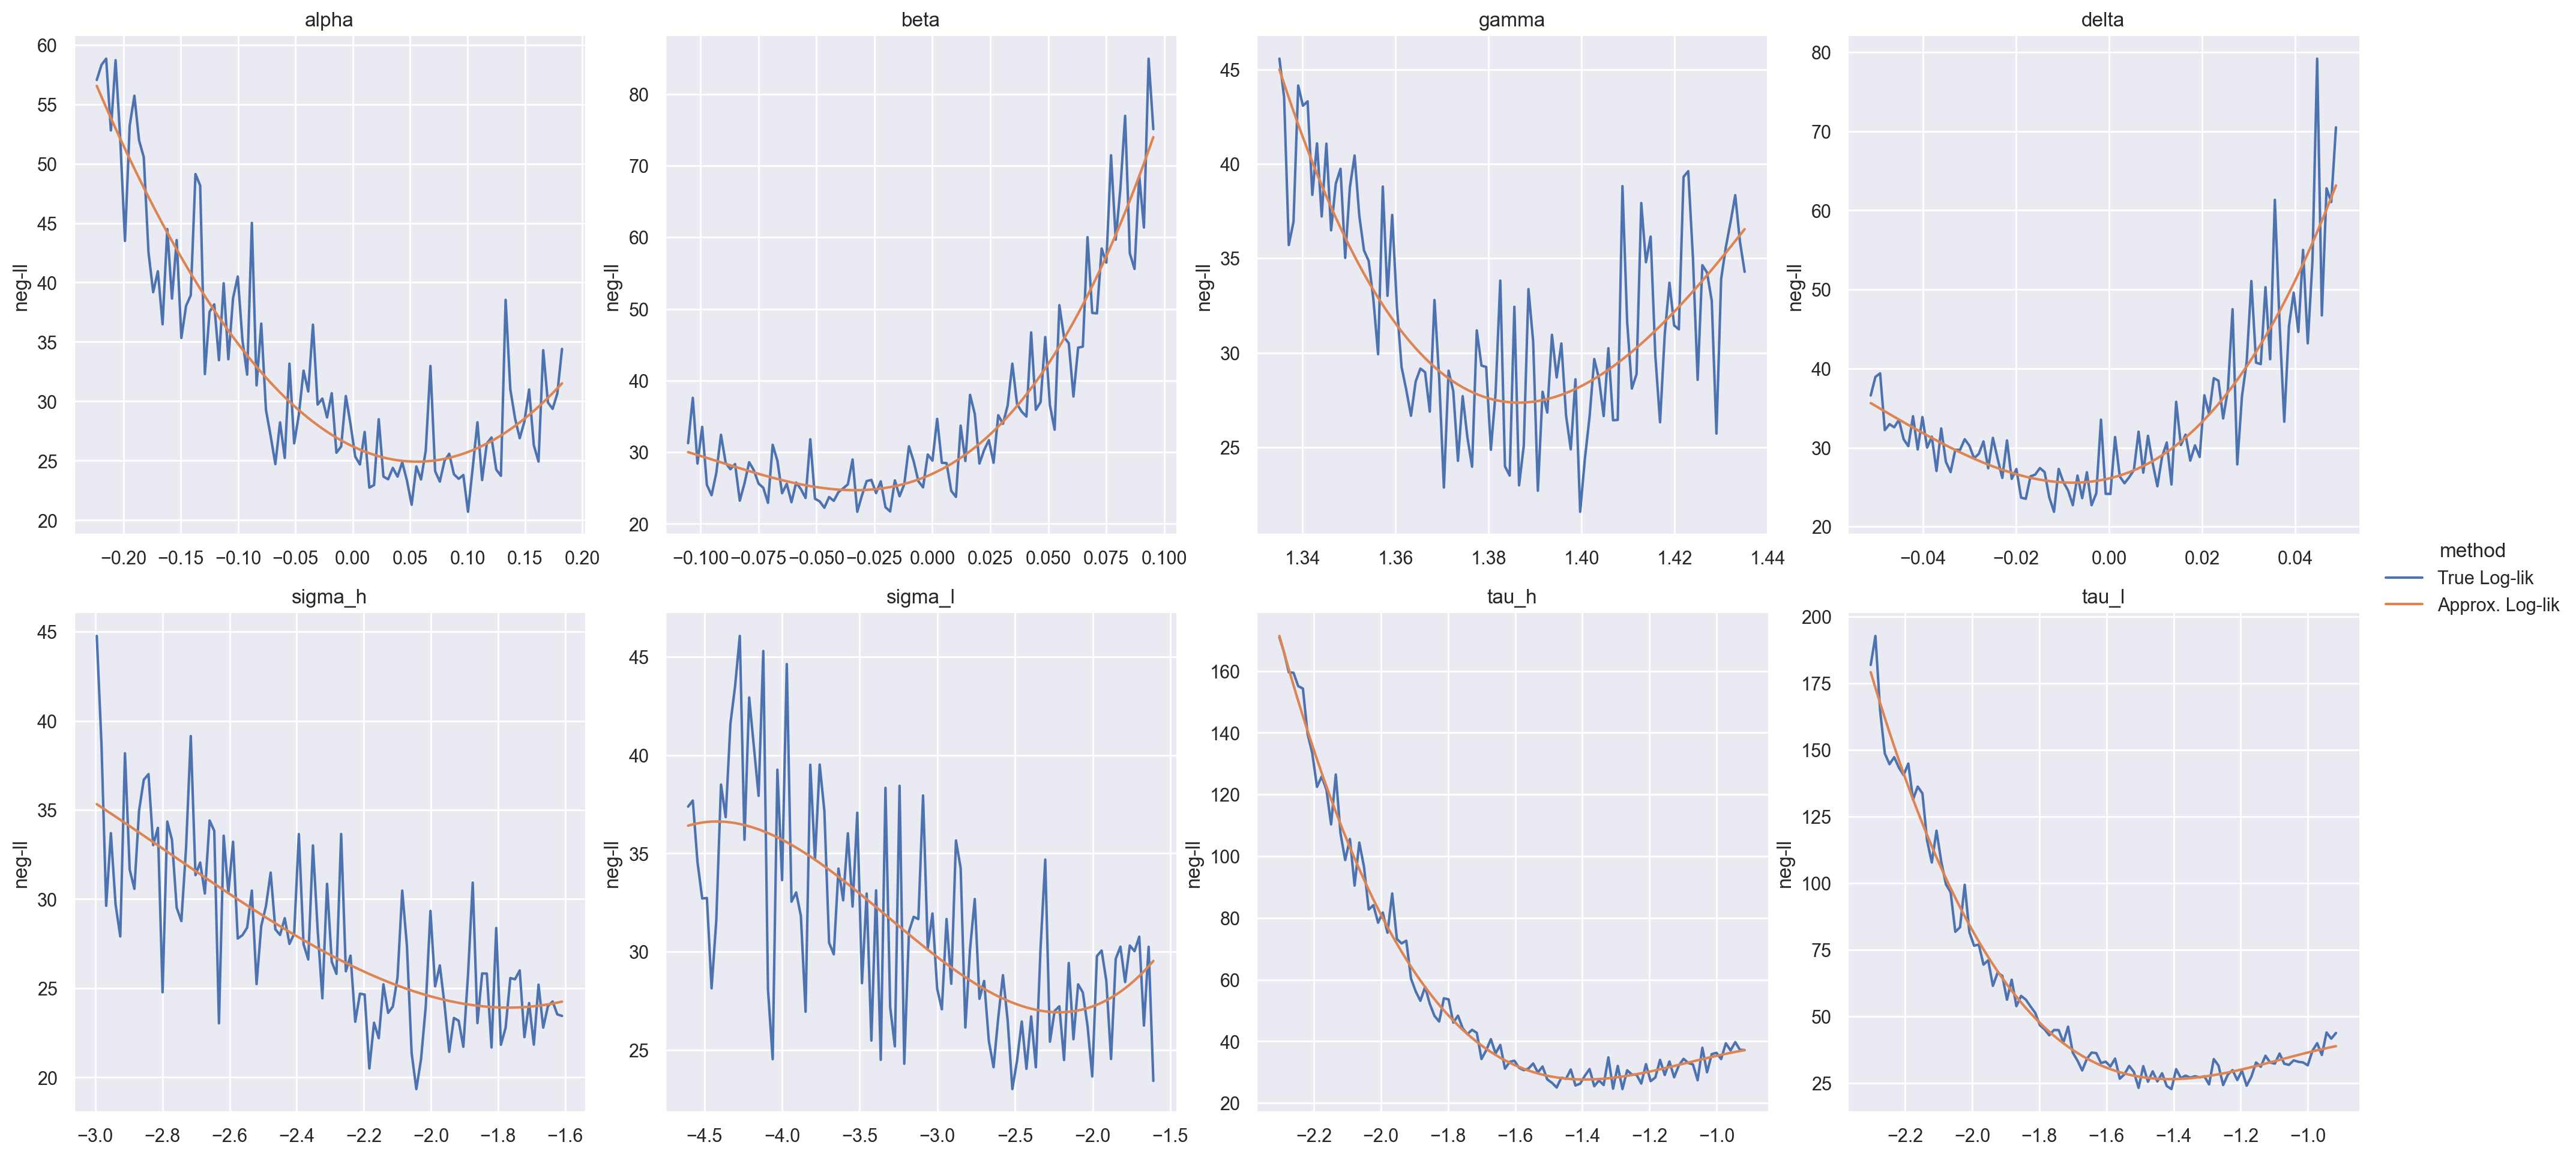

In [229]:
# plot true log-likelihood and its regression approximation
plot_data = pd.melt(data, id_vars=["x", "x_opt", "loglik_grad"], value_name="neg-ll", var_name="method")

# rename for nicer plot: 
plot_data.loc[plot_data.method == "y", "method"] = "True Log-lik"
plot_data.loc[plot_data.method == "y_hat", "method"] = "Approx. Log-lik"

grid = sns.relplot(
    data = plot_data,
    kind="line",
    x="x", y="neg-ll", 
    hue = "method",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None);

In [212]:
key = random.PRNGKey(0)
n_particles = 100
n_sim = 30
key, *subkeys = random.split(key, n_sim+1)

# repeat calculation nsim times
score_auto = []
score_mvn = []
score_gc = []

for i in range(n_sim):
    score_auto += [lv_score_multinom(theta_true_lv, subkeys[i], n_particles)]
    score_mvn += [lv_score_mvn(theta_true_lv, subkeys[i], n_particles)]
    score_gc += [lv_score_gc(theta_true_lv, subkeys[i], n_particles)]

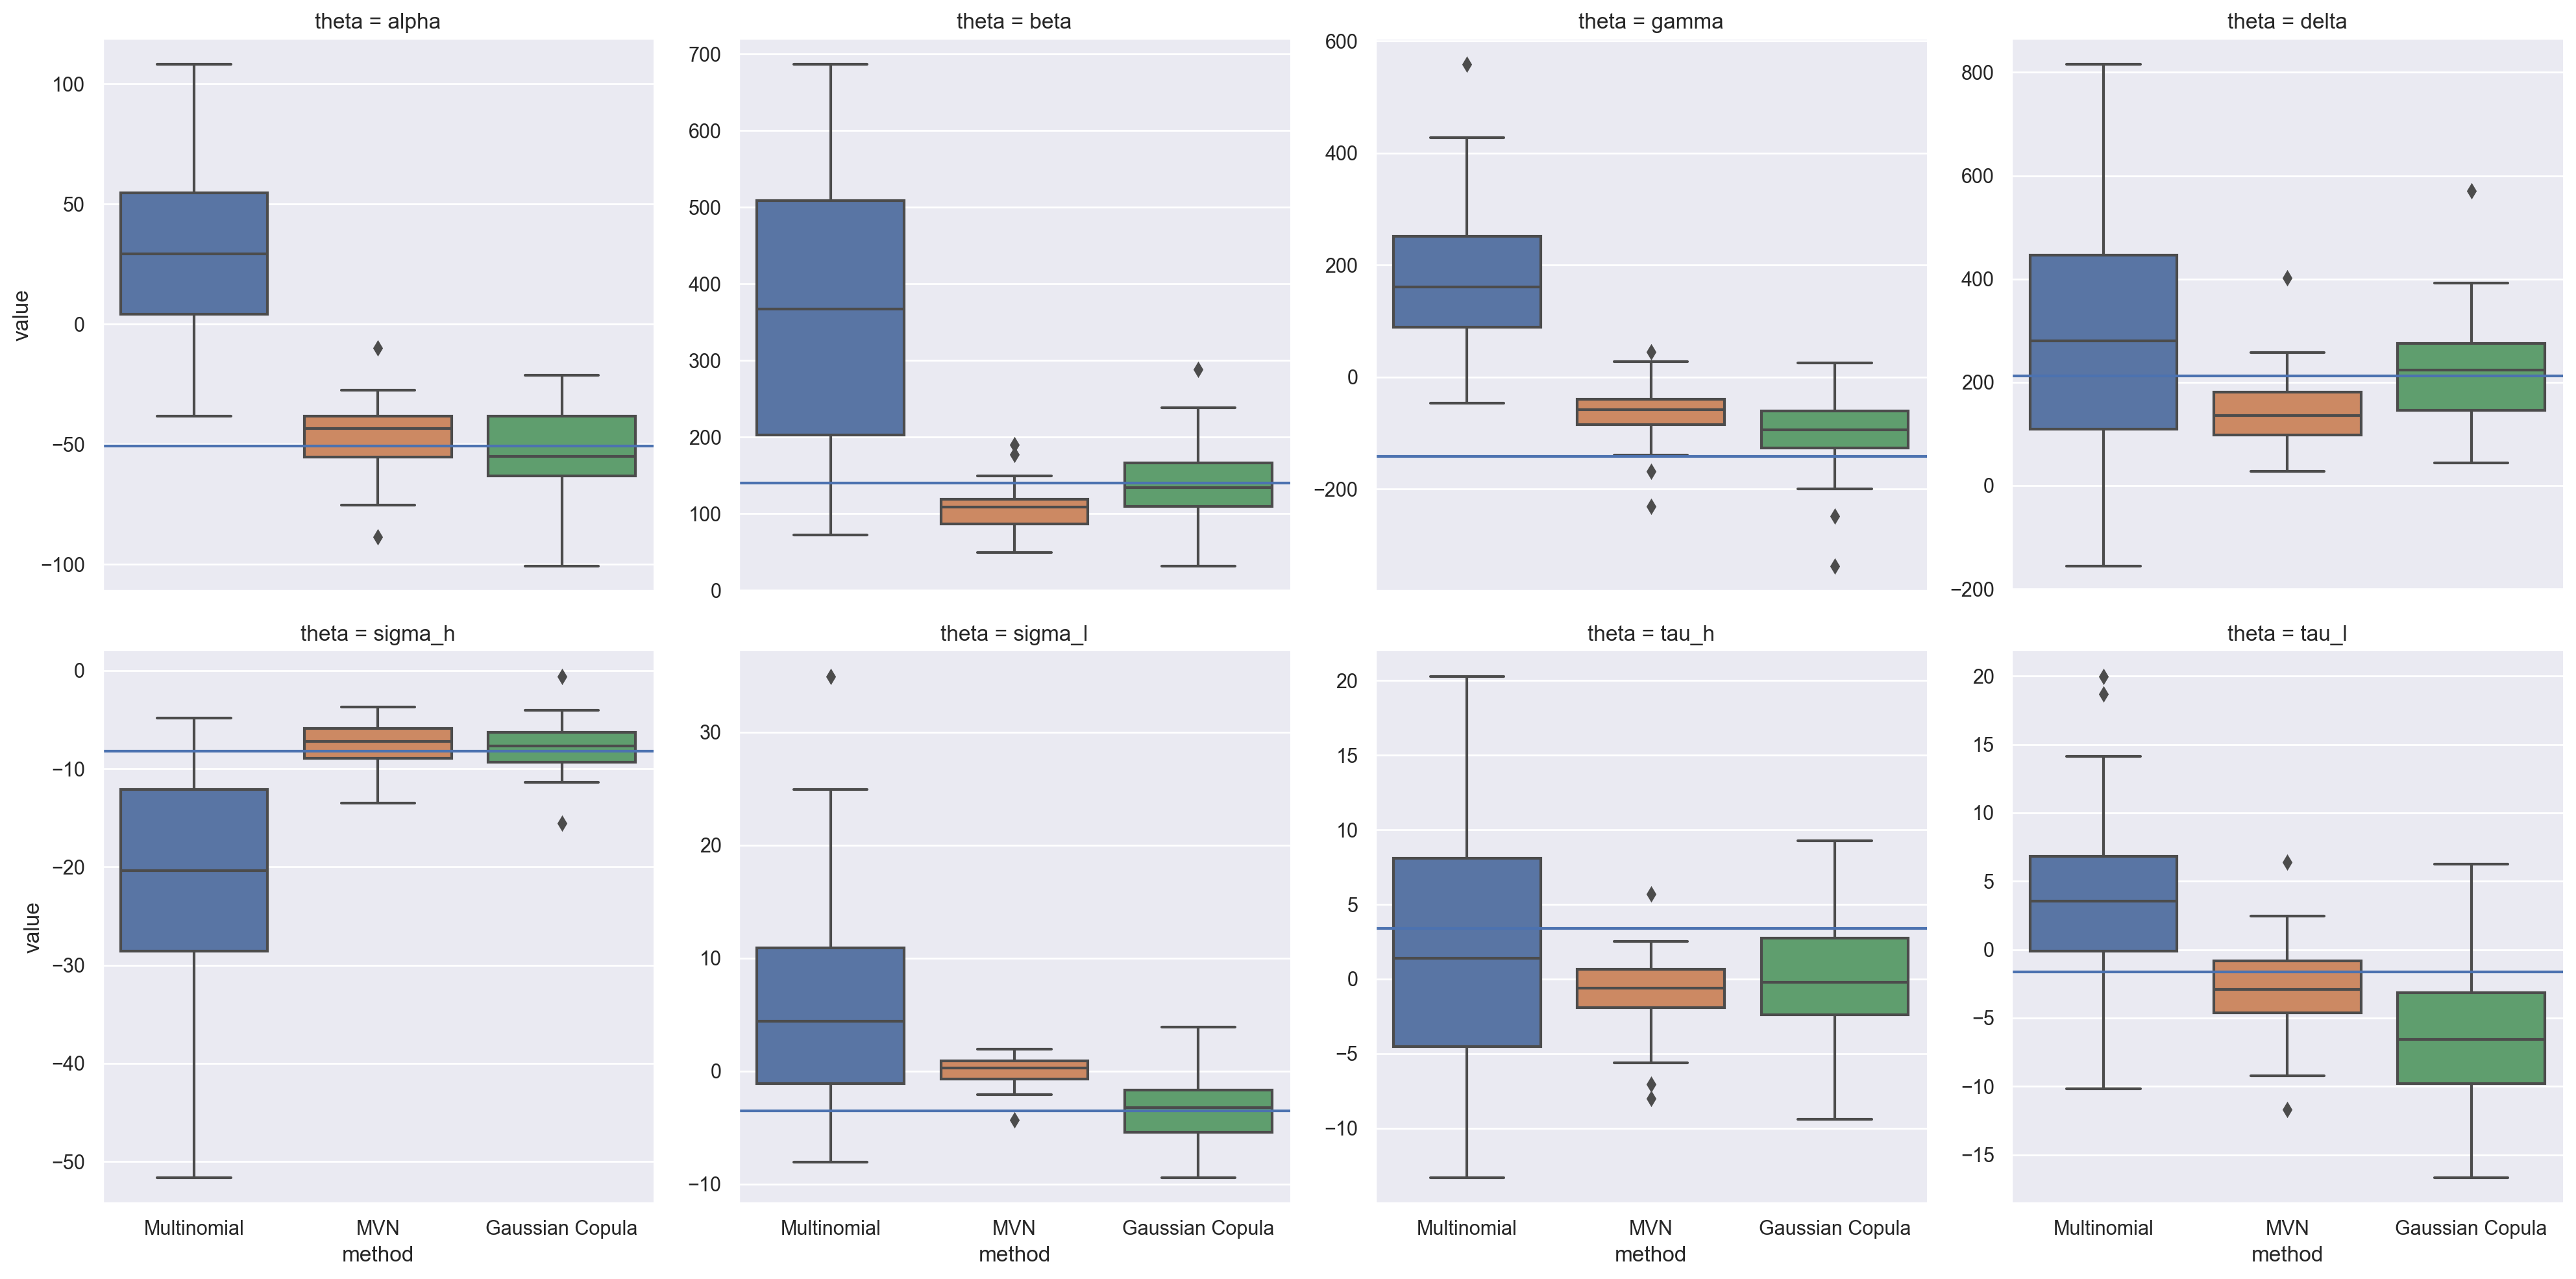

In [214]:
plot_df = (
    pd.DataFrame({
    "theta": np.tile(theta_names_lv, n_sim),
    "Multinomial": np.array(score_auto).ravel(),
    "MVN": np.array(score_mvn).ravel(),
    "Gaussian Copula": np.array(score_gc).ravel()
})
    .melt(id_vars=["theta"], value_vars=["Multinomial", "MVN", "Gaussian Copula"], var_name="method")
)

g = sns.catplot(
    data=plot_df, kind="box",
    x="method", y="value",
    col="theta",
    col_wrap=4,
    sharey=False
)

[g.axes[i].axhline(true_grad[i]) for i in range(true_grad.size)];

## Work-Precision Plots

- Benchmark: Take true params and 5k particles (lots of particles)
- Run basic pf with a diff number of particles with diff seeds each time
- Evaluate the log-lik on each of these particles 100 times each (multiple times each)
- Record the runtime per random seed, for each of the number of particles
- Calculate RMSE for each of the true params and estimated params for each # of particles
- Plot (clock time VS accuracy) for each method. Doesn't have to be the same number of particle for each method, 

In [ ]:
import tqdm

In [ ]:
def run_sim_for (loglik, num_particles, true_params, init_params, n_iters, learning_rates, num_sim=10):
    times = np.zeros((len(num_particles), num_sim))
    mse = np.zeros((len(num_particles), num_sim))
    key = random.PRNGKey(0)
    
    for i in range(len(num_particles)): 
        print("Iteration: ", i)
        
        for j in range(num_sim):
            key, subkey = random.split(key)
            start = time.perf_counter()
            if j % 5 == 0:
                print("   Inner iter: ", j)
            _params, _losses, _steps, _time = simple_grad_descent2(
                subkey = subkey,
                model = lotvol_model,
                grad_fun = loglik,
                y_meas = y_meas,
                theta = init_params,
                learning_rate = learning_rates[i],
                n_iter = n_iters[i],
                n_particles = num_particles[i],
                mask=jnp.ones(len(init_params))
            )
            times[i, j] = time.perf_counter() - start # work measured in clock time
            mse[i, j] = sum((_params - true_params)**2) # MSE of estimates
            
    return times, mse, num_particles


def run_sim (loglik, num_particles, true_params, init_params, n_iters, learning_rates, num_sim=10):
    times = np.zeros(len(num_particles))
    mse = np.zeros(len(num_particles))
    key = random.PRNGKey(10)
    results = []
    for i in tqdm.tqdm(range(len(num_particles))): 
        key, *subkeys = random.split(key, num_sim+1)
        start = time.perf_counter()
        sim_res = jax.vmap(lambda key, lr, n_iter, n_part:
             grad_descent_scan(
                 key = key,
                 model = lotvol_model,
                 grad_fun = loglik,
                 y_meas = y_meas,
                 theta = init_params,
                 learning_rate = lr,
                 n_iter = n_iter,
                 n_particles = n_part,
                 mask=jnp.ones(len(init_params))),
             in_axes = (0, None, None, None))(jnp.array(subkeys), learning_rates[i], n_iters[i], num_particles[i])
        end = time.perf_counter()
        mse[i] = (jnp.mean((sim_res["theta"] - true_params)**2)) # MSE averaged over runs
        times[i] = ((end - start)/num_sim) # average times
        results.append(sim_res)
    return times, mse, num_particles, results

In [ ]:
multinom_particles = [50, 100, 250, 500, 1000]
multinom_times, multinom_mse, multinom_num_particles, multinom_results = run_sim(
    loglik = particle_neg_loglik_bootstrap,
    num_particles = multinom_particles,
    true_params = theta,
    init_params = init_params,
    n_iters = [500, 500, 500, 500, 500],
    learning_rates = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3])

In [ ]:
gc_particles = [10, 25, 50, 100]
gc_times, gc_mse, gc_num_particles, gc_results = run_sim(
    loglik = particle_neg_loglik_gc,
    num_particles = gc_particles,
    true_params = theta,
    init_params = init_params,
    n_iters = [500, 500, 500, 500, 500],
    learning_rates = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3])

In [ ]:
mvn_particles = [50, 100, 250, 500, 1000]
mvn_times, mvn_mse, mvn_num_particles, mvn_results = run_sim(
    loglik = particle_neg_loglik_mvn,
    num_particles = mvn_particles,
    true_params = theta,
    init_params = init_params,
    n_iters = [500, 500, 500, 500, 500],
    learning_rates = [1e-3, 1e-3, 1e-3, 1e-3, 1e-3])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 4), sharey = False)

ax[0].plot(mvn_times, mvn_mse, label = "MVN")
ax[0].plot(gc_times, gc_mse, label = "GC")
ax[0].plot(multinom_times, multinom_mse, label = "Multinomial")
ax[0].set(title="MSE VS Runtime")
ax[0].legend()

ax[1].plot(multinom_particles, mvn_times,  label = "MVN Resampling")
ax[1].plot(gc_particles, gc_times,  label = "GC Resampling")
ax[1].plot(mvn_particles, multinom_times,  label = "Multinomial Resampling")
ax[1].set(title="Number of Particles VS Runtime")
ax[1].legend()

ax[2].plot(list(map(lambda x: np.min(x["losses"]), mvn_results)), label = "MVNN")
ax[2].plot(list(map(lambda x: np.min(x["losses"]), gc_results)), label = "GC")
ax[2].plot(list(map(lambda x: np.min(x["losses"]), multinom_results)), label = "Multinomial");
ax[2].set(title="Min losses after Gradient Descent")
ax[2].legend();

In [ ]:
## EXPERIMENT: MSE VS number of particles for MVN: 
mvn_particles = np.arange(75, 500, step = 75)
mvn_times, mvn_mse, mvn_num_particles, mvn_results = run_sim(
    loglik = particle_neg_loglik_mvn,
    num_particles = mvn_particles,
    true_params = theta,
    init_params = init_params,
#     n_iters = [500] * len(mvn_particles),
    n_iters = [500, 750, 1000, 1200, 1500, 2000],
    learning_rates = [1e-3] * len(mvn_particles),
    num_sim=100)

multinom_particles = np.arange(75, 500, step = 75)
multinom_times, multinom_mse, multinom_num_particles, multinom_results = run_sim(
    loglik = particle_neg_loglik_bootstrap,
    num_particles = multinom_particles,
    true_params = theta,
    init_params = init_params,
#     n_iters = [500] * len(multinom_particles),
    n_iters = [500, 750, 1000, 1200, 1500, 2000],
    learning_rates = [1e-3] * len(multinom_particles),
    num_sim = 100)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey = True)

ax[0].plot(mvn_particles, mvn_mse, label = "MVN")
ax[1].plot(multinom_particles, multinom_mse, label = "multinom")
plt.legend();

### Findings and Questions

- As the number of particles increases, the minimum loss from optimization also increases. Why would this happen? Shouldn't it be around the same value? 
- Not much of an improvement in the MSE when we increase the number of particles

- **Q:** Should we use a constant seed for gradient descent? 


# Brownian Motion Model

In [ ]:
from pfjax.models import BMModel

# initial key for random numbers
key = random.PRNGKey(0)
sns.set_style("darkgrid")
# parameter values
mu = 5.
sigma = .2
tau = 1.
theta_true = jnp.array([mu, sigma, tau])
bm_theta_names = ["mu", "sigma", "tau"]

# data specification
dt = .2
n_obs = 100
x_init = jnp.array(0.)

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = random.split(key)
y_meas, x_state = pf.simulate(bm_model, subkey, n_obs, x_init, theta_true)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)
plt.title("Latent Variable(x_state) and Observation(y_meas)");

In [ ]:
bm_theta_lims = jnp.array([
    [4.8, 5.2],
    [0.1, .3],
    [0.9, 1.1]])

In [ ]:
@partial(jax.jit, static_argnums=(2,))
def bm_neg_loglik_mvn(theta, key, n_particles=500):
    """ negative log-likelihood of PF with MVN resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=bm_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_mvn)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(2,))
def bm_neg_loglik_gc(theta, key, n_particles=250):
    """ negative log-likelihood of PF with GC resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=bm_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key,
        resampler = resampler.resample_gaussian_copula)
    return -ret["loglik"]


@partial(jax.jit, static_argnums=(2,))
def bm_neg_loglik_bootstrap(theta, key, n_particles=500):
    """ negative log-likelihood of PF with multinomial resampling """
    ret = pf.particle_filter(
        theta=theta, 
        model=bm_model, 
        y_meas=y_meas, 
        n_particles=n_particles, 
        key=key)
    return -ret["loglik"]

In [ ]:
# calculate projection plot for exact loglikelihood
df_gc = pjp.proj_plot(
    fun = lambda x: bm_neg_loglik_gc(x, key=_key, n_particles=50), 
    x_opt=theta_true, 
    x_lims=bm_theta_lims, 
    x_names=bm_theta_names, 
    n_pts=300,
    plot=False
)


# calculate projection plot for exact loglikelihood
df_mvn = pjp.proj_plot(
    fun = lambda x: bm_neg_loglik_mvn(x, key=_key, n_particles=50), 
    x_opt=theta_true, 
    x_lims=bm_theta_lims, 
    x_names=bm_theta_names, 
    n_pts=300,
    plot=False
)

# calculate projection plot for particle filter loglikelihood
df_multinom = pjp.proj_plot(
    fun=lambda x: bm_neg_loglik_bootstrap(x, key=_key, n_particles=50),
    x_opt=theta_true, 
    x_lims=bm_theta_lims, 
    x_names=bm_theta_names, 
    n_pts=300,
    plot=False
)

In [ ]:
# merge data frames and plot them
plot_df = pd.concat([df_gc, df_multinom, df_mvn], ignore_index=True)
plot_df["Resampler"] = np.repeat(["Gaussian Copula", "Multinomial", "MVN"], len(df_gc["x_opt"]))
plot_df = plot_df.rename(columns={"y": "neg-loglikelihood"})

grid = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="neg-loglikelihood", 
    hue="Resampler",
    col="x_opt",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)
grid.set_titles(col_template="{col_name}")
grid.set(xlabel=None)

for ind, _ax in enumerate(grid.axes.flat):
    _ax.axvline(theta[ind], color='red', lw = 0.9, label="True")
    _ax.legend();

# References

(<a id="cit-corenflos_etal21" href="#call-corenflos_etal21">Corenflos, Thornton <em>et al.</em>, 2021</a>) A. Corenflos, J. Thornton, G. Deligiannidis <em>et al.</em>, ``_Differentiable particle filtering via entropy-regularized optimal transport_'', Proceedings of the 38th international conference on machine learning, July 2021.  [online](https://proceedings.mlr.press/v139/corenflos21a.html)

(<a id="cit-cappe_moulines05" href="#call-cappe_moulines05">Cappé and Moulines, 2005</a>) O. Cappé and E. Moulines, ``_On the use of particle filtering for maximum likelihood parameter estimation_'', 13th European Signal Processing Conference,  2005.

(<a id="cit-poyiadjis_etal11" href="#call-poyiadjis_etal11">Poyiadjis, Doucet <em>et al.</em>, 2011</a>) Poyiadjis G., Doucet A. and Singh S. S., ``_Particle approximations of the score and observed information matrix in state space models with application to parameter estimation_'', Biometrika, vol. 98, number 1, pp. 65--80,  2011.  [online](https://academic.oup.com/biomet/article-lookup/doi/10.1093/biomet/asq062)

